# McKinney Chapter 10 - Data Aggregation and Group Operations

## Introduction

Chapter 10 of Wes McKinney's [*Python for Data Analysis*](https://wesmckinney.com/pages/book.html) discusses groupby operations, which are the pandas equivalent of Excel pivot tables.
Pivot tables help us calculate statistics (e.g., sum, mean, and median) for one set of variables by groups of other variables (e.g., weekday or year).
For example, we could use a pivot table to calculate mean daily stock returns by weekday.

We will focus on:

1. Using `.groupby()` to group by columns, indexes, and functions
1. Using `.agg()` to aggregate multiple functions
1. Using pivot tables as an alternative to `.groupby()`

***Note:*** Indented block quotes are from McKinney, and section numbers differ from McKinney because we will not discuss every topic.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')
import yfinance as yf
import pandas_datareader as pdr

## GroupBy Mechanics

"Split-apply-combine" is an excellent way to describe and visualize pandas groupby operations.

> Hadley Wickham, an author of many popular packages for the R programming 
language, coined the term split-apply-combine for describing group operations. In the
first stage of the process, data contained in a pandas object, whether a Series, DataFrame, or otherwise, is split into groups based on one or more keys that you provide.
The splitting is performed on a particular axis of an object. For example, a DataFrame
can be grouped on its rows (axis=0) or its columns (axis=1). Once this is done, a
function is applied to each group, producing a new value. Finally, the results of all
those function applications are combined into a result object. The form of the resulting object will usually depend on what’s being done to the data. See Figure 10-1 for a
mockup of a simple group aggregation.

Figure 10-1 visualizes a pandas groupby operation that:

1. Splits the dataframe by the `key` column (i.e., "groups by `key`")
2. Applies the sum operation to the `data` column (i.e., "sums `data`")
3. Combines the grouped sums

I describe this operation as "sum the `data` column by (gruops formed on) the `key` column."

In [4]:
np.random.seed(42)
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [5]:
df

,key1,key2,data1,data2
0,a,one,0.4967,-0.2341
1,a,two,-0.1383,1.5792
2,b,one,0.6477,0.7674
3,b,two,1.5230,-0.4695
4,a,one,-0.2342,0.5426


Here is one way to calculate the means of `data1` by (grouops formed on) `key1`.

In [6]:
df.loc[df['key1'] == 'a', 'data1'].mean()

0.0414

In [7]:
df.loc[df['key1'] == 'b', 'data1'].mean()

1.0854

We can do this calculation more quickly:

1. Use the `.groupby()` method to group by `key1`
2. Use the `.mean()` method to sum `data1` within each value of `key1`

Note that without the `.mean()` method, pandas only sets up the grouped object, which can accept the `.mean()` method.

In [8]:
grouped = df['data1'].groupby(df['key1'])

In [9]:
grouped

In [10]:
grouped.mean()

key1
a   0.0414
b   1.0854
Name: data1, dtype: float64

We can can chain the `.groupby()` and `.mean()` methods.

In [11]:
df['data1'].groupby(df['key1']).mean()

key1
a   0.0414
b   1.0854
Name: data1, dtype: float64

---
***What does `np.random.randn(5)` do?***
The funtion `np.random.randn()` creates 5 standard normal random variables (mean of 0 and standard deviation of 1).

In [12]:
np.random.seed(42)
randos = np.random.randn(1_000_000)
print(f'Mean of {randos.mean():0.4f}, standard deviation of {randos.std():0.4f}')

Mean of -0.0016, standard deviation of 1.0002


---

If we prefer our result as a dataframe instead of a series, we can wrap `data1` with two sets of square brackets.

In [13]:
df[['data1']].groupby(df['key1']).mean()

,data1
key1,
a,0.0414
b,1.0854


We can group by more than one variable.
We get a hierarchical row index (or row multi-index) when we group by more than one variable.

In [14]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.1313
      two    -0.1383
b     one     0.6477
      two     1.5230
Name: data1, dtype: float64

We can use the `.unstack()` method if we want to use both rows and columns to organize data.
Note that, the `.unstack()` method un-stacks the last dimension (i.e., `level = -1`) by default so that `key2` values become columns.

In [15]:
means.unstack()

key2,one,two
key1,,
a,0.1313,-0.1383
b,0.6477,1.5230


The grouping variables can also be columns in the data frame passed to the `.groupby()` method.
I prefer this approach because we will typically have all data in one data frame.

In [16]:
df.groupby('key1')[['data1', 'data2']].mean()

,data1,data2
key1,,
a,0.0414,0.6292
b,1.0854,0.1490


In [17]:
df.groupby(['key1', 'key2']).mean()

data1   data2
key1 key2                
a    one   0.1313  0.1542
     two  -0.1383  1.5792
b    one   0.6477  0.7674
     two   1.5230 -0.4695

There are many more methods than `.mean()`.
We can use tab completion to discover (or remind ourselves of) these other methods.

### Iterating Over Groups

We can iterate over groups, too.
The `.groupby()` method generates a sequence of tuples.
Each tuples contains the value(s) of the grouping variable(s) and associated chunk of the dataframe.
McKinney provides two loops to show how to iterate over groups.

In [18]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2   data1   data2
0    a  one  0.4967 -0.2341
1    a  two -0.1383  1.5792
4    a  one -0.2342  0.5426
b
  key1 key2  data1   data2
2    b  one 0.6477  0.7674
3    b  two 1.5230 -0.4695


In [19]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2   data1   data2
0    a  one  0.4967 -0.2341
4    a  one -0.2342  0.5426
('a', 'two')
  key1 key2   data1  data2
1    a  two -0.1383 1.5792
('b', 'one')
  key1 key2  data1  data2
2    b  one 0.6477 0.7674
('b', 'two')
  key1 key2  data1   data2
3    b  two 1.5230 -0.4695


### Selecting a Column or Subset of Columns

We preview the idea of grouping an entire dataframe above.
However, I want to take this chance to explain McKinney's use of the phrase "syntactic sugar."
Here is the context:

> Indexing a GroupBy object created from a DataFrame with a column name or array
of column names has the effect of column subsetting for aggregation. This means
that:
>
> ```
> df.groupby('key1')['data1']
> df.groupby('key1')[['data2']]
> ```
>
> are syntactic sugar for
>
> ```
> df['data1'].groupby(df['key1'])
> df[['data2']].groupby(df['key1'])
> ```

"Syntactic sugar" makes code easier to type or read without adding functionality.
It makes code "sweeter" for humans to type or read by making it more concise or clear.
The implication is that syntactic sugar makes code faster to type/read but does make code faster to execute.

In [20]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2        
a    one   0.1542
     two   1.5792
b    one   0.7674
     two  -0.4695

### Grouping with Functions

We can also group with functions.
Below, we group with the `len` function, which calculates the length of the first names in the row index.
We could instead add a helper column to `people`, but it is easier to pass a function to `.groupby()`.

In [21]:
np.random.seed(42)
people = pd.DataFrame(
    data=np.random.randn(5, 5), 
    columns=['a', 'b', 'c', 'd', 'e'], 
    index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis']
)
people

,a,b,c,d,e
Joe,0.4967,-0.1383,0.6477,1.5230,-0.2342
Steve,-0.2341,1.5792,0.7674,-0.4695,0.5426
Wes,-0.4634,-0.4657,0.2420,-1.9133,-1.7249
Jim,-0.5623,-1.0128,0.3142,-0.9080,-1.4123
Travis,1.4656,-0.2258,0.0675,-1.4247,-0.5444


In [22]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.5290,-1.6168,1.2039,-1.2983,-3.3714
5,-0.2341,1.5792,0.7674,-0.4695,0.5426
6,1.4656,-0.2258,0.0675,-1.4247,-0.5444


We can mix functions, lists, etc. that we pass to `.groupby()`.

In [23]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a       b      c       d       e
3 one -0.4634 -0.4657 0.2420 -1.9133 -1.7249
  two -0.5623 -1.0128 0.3142 -0.9080 -1.4123
5 one -0.2341  1.5792 0.7674 -0.4695  0.5426
6 two  1.4656 -0.2258 0.0675 -1.4247 -0.5444

In [24]:
d = {'Joe': 'a', 'Jim': 'b'}
people.groupby([len, d]).min()

a       b      c       d       e
3 a  0.4967 -0.1383 0.6477  1.5230 -0.2342
  b -0.5623 -1.0128 0.3142 -0.9080 -1.4123

In [25]:
d_2 = {'Joe': 'Cool', 'Jim': 'Nerd', 'Travis': 'Cool'}
people.groupby([len, d_2]).min()

a       b      c       d       e
3 Cool  0.4967 -0.1383 0.6477  1.5230 -0.2342
  Nerd -0.5623 -1.0128 0.3142 -0.9080 -1.4123
6 Cool  1.4656 -0.2258 0.0675 -1.4247 -0.5444

### Grouping by Index Levels

We can also group by index levels.
We can specify index levels by either level number or name.

In [26]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [27]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [28]:
hier_df.groupby(level='cty', axis='columns').count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [29]:
hier_df.groupby(level='tenor', axis=1).count()

tenor,1,3,5
0,2,2,1
1,2,2,1
2,2,2,1
3,2,2,1


## Data Aggregation

Table 10-1 provides the optimized groupby methods:

- `count`: Number of non-NA values in the group
- `sum`: Sum of non-NA values
- `mean`: Mean of non-NA values
- `median`: Arithmetic median of non-NA values
- `std`, `var`: Unbiased (n – 1 denominator) standard deviation and variance
- `min`, `max`: Minimum and maximum of non-NA values
- `prod`: Product of non-NA values
- `first`, `last`: First and last non-NA values

These optimized methods are fast and efficient, but pandas does not limit us to these methods.
First, any series method is available.

In [30]:
df.groupby('key1')['data1'].quantile(0.9)

key1
a   0.3697
b   1.4355
Name: data1, dtype: float64

Second, we can write our own functions and pass them to the `.agg()` method.
These functions should accept an array and returns a single value.

In [31]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [32]:
df.groupby('key1')['data1'].agg(peak_to_peak)

key1
a   0.7309
b   0.8753
Name: data1, dtype: float64

Some other methods work, too, even if they are do not aggregate an array to a single value.

In [33]:
df.groupby('key1')['data1'].describe()

,count,mean,std,min,25%,50%,75%,max
key1,,,,,,,,
a,3.0000,0.0414,0.3972,-0.2342,-0.1862,-0.1383,0.1792,0.4967
b,2.0000,1.0854,0.6190,0.6477,0.8665,1.0854,1.3042,1.5230


### Column-Wise and Multiple Function Application

The `.agg()` methods provides two more handy features:

1. We can pass multiple functions to operate on all of the columns
2. We can pass specific functions to operate on specific columns

Here is an example with multiple functions:

In [34]:
df.groupby('key1')['data1'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
key1,,,,
a,0.0414,-0.1383,-0.2342,0.4967
b,1.0854,1.0854,0.6477,1.5230


In [35]:
df.groupby('key1')[['data1', 'data2']].agg(['mean', 'median', 'min', 'max'])

data1                         data2                      
       mean  median     min    max   mean median     min    max
key1                                                           
a    0.0414 -0.1383 -0.2342 0.4967 0.6292 0.5426 -0.2341 1.5792
b    1.0854  1.0854  0.6477 1.5230 0.1490 0.1490 -0.4695 0.7674

What if I wanted to calculate the mean of `data1` and the median of `data2` by `key1`?

In [36]:
df.groupby('key1').agg({'data1': 'mean', 'data2': 'median'})

,data1,data2
key1,,
a,0.0414,0.5426
b,1.0854,0.1490


What if I wanted to calculate the mean *and standard deviation* of `data1` and the median of `data2` by `key1`?

In [37]:
df.groupby('key1').agg({'data1': ['mean', 'std'], 'data2': 'median'})

data1         data2
       mean    std median
key1                     
a    0.0414 0.3972 0.5426
b    1.0854 0.6190 0.1490

## Apply: General split-apply-combine

The `.agg()` method aggrates an array to a single value.
We can use the `.apply()` method for more general calculations.

We can combine the `.groupby()` and `.apply()` methods to:

1. Split a dataframe by grouping variables
2. Call the applied function on each chunk of the original dataframe
3. Recombine the output of the applied function

In [38]:
def top(x, col, n=1):
    return x.sort_values(col).head(n)

In [39]:
df.groupby('key1').apply(top, col='data1', n=2)

key1 key2   data1   data2
key1                            
a    4    a  one -0.2342  0.5426
     1    a  two -0.1383  1.5792
b    2    b  one  0.6477  0.7674
     3    b  two  1.5230 -0.4695

In [40]:
df.groupby('key1').apply(top, col='data2', n=2)

key1 key2   data1   data2
key1                            
a    0    a  one  0.4967 -0.2341
     4    a  one -0.2342  0.5426
b    3    b  two  1.5230 -0.4695
     2    b  one  0.6477  0.7674

## Pivot Tables and Cross-Tabulation

Above we manually made pivot tables with the `groupby()`, `.agg()`, `.apply()` and `.unstack()` methods.
pandas provides a literal interpreation of Excel-style pivot tables with the `.pivot_table()` method and the `pandas.pivot_table()` function.
These also provide row and column totals via "margins".
It is worthwhile to read-through the `.pivot_table()` docstring several times.

In [41]:
ind = (
    yf.download(tickers='^GSPC ^DJI ^IXIC ^FTSE ^N225 ^HSI', session=session)
    .rename_axis(columns=['Variable', 'Index'])
    .stack()
)

[                       0%                       ]

[****************      33%                       ]  2 of 6 completed

[**********************50%                       ]  3 of 6 completed

[**********************67%*******                ]  4 of 6 completed

[**********************83%***************        ]  5 of 6 completed

[*********************100%***********************]  6 of 6 completed

The default aggregation function for `.pivot_table()` is `mean`.

In [42]:
ind.loc['2015':].pivot_table(index='Index')

Variable,Adj Close,Close,High,Low,Open,Volume
Index,,,,,,
^DJI,25132.0667,25132.0667,25269.4015,24980.7143,25129.8955,285964454.0376
^FTSE,6954.3162,6954.3162,6996.4257,6911.1154,6954.0995,807504333.4684
^GSPC,2960.4648,2960.4648,2976.4686,2942.3839,2960.2395,3854102051.8029
^HSI,25304.6543,25304.6543,25467.9247,25134.0835,25322.2698,1951973748.5729
^IXIC,8489.0052,8489.0052,8546.2471,8423.7903,8488.5611,2967972097.5114
^N225,22271.7938,22271.7938,22391.3915,22144.1387,22273.8385,96057591.6230


We can use 
    `values` to select specific variables, 
    `pd.Grouper()` to sample different date windows, 
    and 
    `aggfunc` to select specific aggregation functions.

In [43]:
(
    ind
    .loc['2015':]
    .reset_index()
    .pivot_table(
        values='Close',
        index=pd.Grouper(key='Date', freq='A'),
        columns='Index',
        aggfunc=['min', 'max']
    )
)

min                                                       \
Index            ^DJI     ^FTSE     ^GSPC       ^HSI      ^IXIC      ^N225   
Date                                                                         
2015-12-31 15666.4404 5874.1001 1867.6100 20556.5996  4506.4902 16795.9609   
2016-12-31 15660.1797 5537.0000 1829.0800 18319.5801  4266.8398 14952.0195   
2017-12-31 19732.4004 7099.2002 2257.8301 22134.4707  5429.0801 18335.6309   
2018-12-31 21792.1992 6584.7002 2351.1001 24585.5293  6192.9199 19155.7402   
2019-12-31 22686.2207 6692.7002 2447.8899 25064.3594  6463.5000 19561.9609   
2020-12-31 18591.9297 4993.8999 2237.3999 21696.1309  6860.6699 16552.8301   
2021-12-31 29982.6191 6407.5000 3700.6499 22744.8594 12609.1602 27013.2500   
2022-12-31 28725.5098 6826.2002 3577.0300 15165.5898 10321.3896 24717.5293   

                  max                                                       
Index            ^DJI     ^FTSE     ^GSPC       ^HSI      ^IXIC      ^N225  
Date                                                                        
2015-12-31 18312.3906 7104.0000 2130.8201 28442.7500  5218.8599 20868.0293  
2016-12-31 19974.6191 7142.7998 2271.7200 24099.6992  5487.4399 19494.5293  
2017-12-31 24837.5098 7687.7998 2690.1599 30003.4902  6994.7598 22939.1797  
2018-12-31 26828.3906 7877.5000 2930.7500 33154.1211  8109.6899 24270.6191  
2019-12-31 28645.2598 7686.6001 3240.0200 30157.4902  9022.3896 24066.1191  
2020-12-31 30606.4805 7674.6001 3756.0701 29056.4199 12899.4199 27568.1504  
2021-12-31 36488.6289 7420.7002 4793.0601 31084.9395 16057.4404 30670.0996  
2022-12-31 36799.6484 7672.3999 4796.5601 24965.5508 15832.7998 29332.1602

## Practice

***Practice:***
Calculate the means of columns `data1` and `data2` by `key1` and `key2`, and arrange the results so that values of `key1` are in the rows and values of `key2` are in the columns.

In [44]:
np.random.seed(42)
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [45]:
# [['data1', 'data2']] is optional because those are the only remaining columns
practice_1 = df.groupby(['key1', 'key2'])[['data1', 'data2']].mean().unstack()
practice_1

data1          data2        
key2    one     two    one     two
key1                              
a    0.1313 -0.1383 0.1542  1.5792
b    0.6477  1.5230 0.7674 -0.4695

***Practice:***
Replicate the previous practice exercise with `pd.pivot_table()` and test equality with `np.allclose()`.
We will learn more about `pd.pivot_table()` at the end of this notebook, but we can give it a try now.

In [46]:
practice_2 = pd.pivot_table(
    data=df,
    values=['data1', 'data2'],
    index='key1',
    columns='key2',
    aggfunc='mean' # I often specify a function, even if it is the default, because I do not trust myself
)
practice_2

data1          data2        
key2    one     two    one     two
key1                              
a    0.1313 -0.1383 0.1542  1.5792
b    0.6477  1.5230 0.7674 -0.4695

In [47]:
np.allclose(practice_1, practice_2)

True

Once you are comfortable with `pd.pivot_table()`, you could do the following:

In [48]:
df.pivot_table(index='key1', columns='key2')

data1          data2        
key2    one     two    one     two
key1                              
a    0.1313 -0.1383 0.1542  1.5792
b    0.6477  1.5230 0.7674 -0.4695

We can specify a list of aggregation functions.

In [49]:
df.pivot_table(index='key1', columns='key2', aggfunc=['mean', 'median', 'min', 'max'])

mean                        median                            min  \
      data1          data2          data1          data2           data1   
key2    one     two    one     two    one     two    one     two     one   
key1                                                                       
a    0.1313 -0.1383 0.1542  1.5792 0.1313 -0.1383 0.1542  1.5792 -0.2342   
b    0.6477  1.5230 0.7674 -0.4695 0.6477  1.5230 0.7674 -0.4695  0.6477   

                                max                         
               data2          data1          data2          
key2     two     one     two    one     two    one     two  
key1                                                        
a    -0.1383 -0.2341  1.5792 0.4967 -0.1383 0.5426  1.5792  
b     1.5230  0.7674 -0.4695 0.6477  1.5230 0.7674 -0.4695

***Practice:***
Calculate the sum of columns `a` through `e` by groups formed on the last letter in each name.
*Hint:* use an anonymous (lambda) function.

In [50]:
np.random.seed(42)
people = pd.DataFrame(
    data=np.random.randn(5, 5), 
    columns=['a', 'b', 'c', 'd', 'e'], 
    index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis']
)
people

,a,b,c,d,e
Joe,0.4967,-0.1383,0.6477,1.5230,-0.2342
Steve,-0.2341,1.5792,0.7674,-0.4695,0.5426
Wes,-0.4634,-0.4657,0.2420,-1.9133,-1.7249
Jim,-0.5623,-1.0128,0.3142,-0.9080,-1.4123
Travis,1.4656,-0.2258,0.0675,-1.4247,-0.5444


In [51]:
people.groupby(lambda x: x[-1]).sum()

,a,b,c,d,e
e,0.2626,1.4409,1.4151,1.0536,0.3084
m,-0.5623,-1.0128,0.3142,-0.9080,-1.4123
s,1.0022,-0.6915,0.3095,-3.3380,-2.2693


***Practice:***
Use the `.to_clipboard()` method to check your answer to the previous practice exercise.

In [52]:
# people.to_clipboard() # only works on a local installation

We need data for the following two practice exercises.
We have to jump through some hoops with `pd.MultiIndex.from_product()` if we want to take full advantage of pandas multi indexes.

In [53]:
faang = yf.download(tickers='META AAPL AMZN NFLX GOOG', session=session)
faang.columns.names = ['Variable', 'Ticker']
faang[pd.MultiIndex.from_product([['Return'], faang['Adj Close'].columns])] = faang['Adj Close'].pct_change()

[                       0%                       ]

[*******************   40%                       ]  2 of 5 completed

[**********************60%****                   ]  3 of 5 completed

[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed

***Practice:***
For the FAANG stocks, calulate the mean and standard deviation of returns by ticker.

In [54]:
faang.stack().groupby(level='Ticker').agg({'Return': ['mean', 'std']})

Variable Return       
           mean    std
Ticker                
AAPL     0.0011 0.0283
AMZN     0.0017 0.0362
GOOG     0.0010 0.0193
META     0.0008 0.0246
NFLX     0.0017 0.0360

***Practice:***
For the FAANG stocks, calulate the mean and standard deviation of returns and the maximum of closing prices by ticker.
To do this, pass a dictionary where the keys are the column names and the values are lists of functions.

In [55]:
faang.stack().groupby(level='Ticker').agg({'Return': ['mean', 'std'], 'Close': 'max'})

Variable Return           Close
           mean    std      max
Ticker                         
AAPL     0.0011 0.0283 182.0100
AMZN     0.0017 0.0362 186.5705
GOOG     0.0010 0.0193 150.7090
META     0.0008 0.0246 382.1800
NFLX     0.0017 0.0360 691.6900

What if we wanted these aggreations by ticker-month?
(We will learn a slightly easier approach in chapter 11 of McKinney.)

In [56]:
(
    faang # our original data with column multi-index for Variable and Ticker
    .stack() # moves Ticker from column inner level to row inner level, so data are Date-Ticker pairs
    .reset_index(level='Ticker') # removes Ticker from index, so index is Date only
    .groupby([
        'Ticker', # group by Ticker
        pd.Grouper(freq='M') # then, group by the month of each Date
    ])
    # .mean() # aggregates the mean of each column
    .agg({'Return': ['mean', 'std'], 'Close': 'max'}) # aggregates with column-specific functions
)

Variable           Return           Close
                     mean    std      max
Ticker Date                              
AAPL   1980-12-31  0.0155 0.0499   0.1607
       1981-01-31 -0.0085 0.0305   0.1540
       1981-02-28 -0.0027 0.0381   0.1283
       1981-03-31 -0.0030 0.0333   0.1194
       1981-04-30  0.0076 0.0347   0.1306
...                   ...    ...      ...
NFLX   2022-06-30 -0.0050 0.0399 205.0900
       2022-07-31  0.0132 0.0352 226.7500
       2022-08-31  0.0001 0.0265 249.3000
       2022-09-30  0.0031 0.0371 245.2000
       2022-10-31  0.0144 0.0489 298.6200

[1400 rows x 3 columns]

We can check our work the old-fashioned way:

In [57]:
faang.stack().loc[('1980-12', 'AAPL')].mean()

Variable
Adj Close           0.1059
Close               0.1359
High                0.1365
Low                 0.1359
Open                0.1361
Volume      103450092.3077
Return              0.0155
dtype: float64

In [58]:
faang.stack().loc[('2022-10', 'NFLX')].mean()

Variable
Adj Close        249.8383
Close            249.8383
High             256.3433
Low              242.4600
Open             248.2522
Volume      16840011.1111
Return             0.0144
dtype: float64

***Practice:***

1. Download all available daily data for the S&P 500 ETF and Google stock (tickers SPY and GOOG)
2. Calculate daily returns
3. Calculate the volatility (standard deviation) of daily returns *every month* by combining `pd.Grouper()` and `.groupby()`)
4. Multiply by $\sqrt{252}$ to annualize these volatilities of daily returns
5. Plot these annualized volatilities

In [59]:
ret_1 = yf.download(tickers='SPY GOOG', session=session)['Adj Close'].pct_change()
ret_1.columns.name = 'Ticker'

[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

In [60]:
vol_1 = ret_1.groupby(pd.Grouper(freq='M')).std()

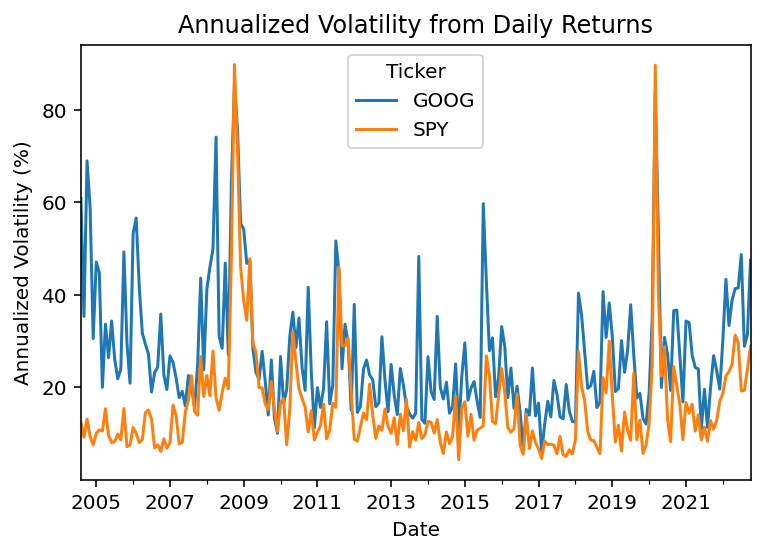

In [61]:
vol_1.dropna().mul(100 * np.sqrt(252)).plot()
plt.ylabel('Annualized Volatility (%)')
plt.title('Annualized Volatility from Daily Returns')
plt.show()

In a few days, we will learn how to more easily perform this aggregation with the `.resample()` method.
Still, `pd.Grouper()` is a great to tool to know because you may want to aggregate along several dimensions, which is not possible with the `.resample()` method.

In [62]:
vol_2 = ret_1.resample('M').std() 

In [63]:
np.allclose(vol_1, vol_2, equal_nan=True)

True

***Practice:***

1. Download the daily factor data from Ken French's website
1. Calculate daily market returns by summing the market risk premium and risk-free rates (`Mkt-RF` and `RF`, respectively)
1. Calculate the volatility (standard deviation) of daily returns *every month* by combining `pd.Grouper()` and `.groupby()`)
1. Multiply by $\sqrt{252}$ to annualize these volatilities of daily returns
1. Plot these annualized volatilities

Is market volatility higher during wars?
Consider the following dates:

1. WWII: December 1941 to September 1945
1. Korean War: 1950 to 1953
1. Viet Nam War: 1959 to 1975
1. Gulf War: 1990 to 1991
1. War in Afghanistan: 2001 to 2021

In [64]:
pdr.famafrench.get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [65]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900-01-01', session=session)[0] / 100

In [66]:
ff['Mkt'] = ff['Mkt-RF'] + ff['RF']

In [67]:
vol_3 = ff['Mkt'].groupby(pd.Grouper(freq='M')).std()

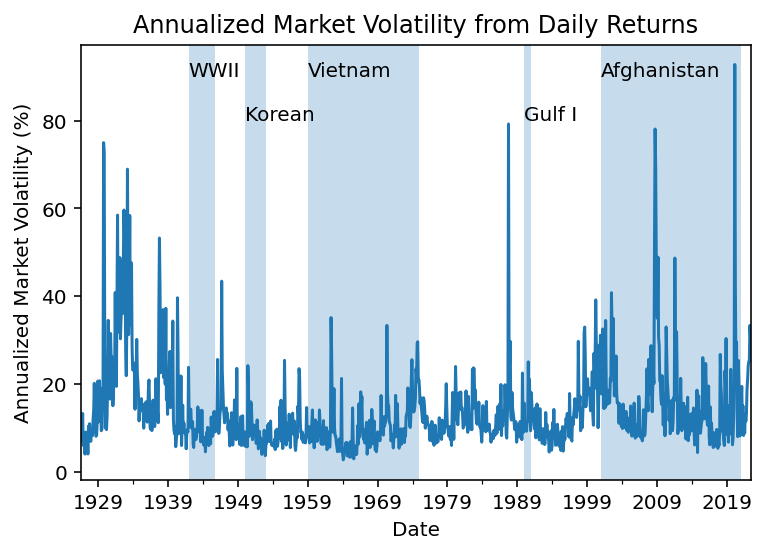

In [68]:
vol_3.dropna().mul(100 * np.sqrt(252)).plot()
plt.axvspan('1941-12', '1945-09', alpha=0.25)
plt.annotate('WWII', ('1941-12', 90))
plt.axvspan('1950', '1953', alpha=0.25)
plt.annotate('Korean', ('1950', 80))
plt.axvspan('1959', '1975', alpha=0.25)
plt.annotate('Vietnam', ('1959', 90))
plt.axvspan('1990', '1991', alpha=0.25)
plt.annotate('Gulf I', ('1990', 80))
plt.axvspan('2001', '2021', alpha=0.25)
plt.annotate('Afghanistan', ('2001', 90))
plt.ylabel('Annualized Market Volatility (%)')
plt.title('Annualized Market Volatility from Daily Returns')
plt.show()